In [1]:
# import required libraries to munge data
import pandas as pd
import numpy as np
import os

In [2]:
# import matplotlib to draw plot inside of notebook
%matplotlib inline
from mpl_toolkits.mplot3d.axes3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm

In [3]:
from math import log
def log_scale(list, base=2):
    """apply log2 function to all list item"""
    for i in range(len(list)):
        list[i] = log(list[i], base)
    return list

In [4]:
merged_corr_table = pd.read_csv("../../log/correlation3.csv", header=0)
merged_corr_table.head(5)

,Timestamp,Msec,Setting,Measure Type,Step,Epoch,Elapsed Time,Test Error,Validation Error,Training Error,BASE_LEARNING_RATE,CONV1_DEPTH,CONV2_DEPTH,FC1_WIDTH,FILTER_SIZE,REGULARIZER_FACTOR
0,2016-12-26 17:41:42,942,/root/tf-hpolib/tf-hpo/src/.config/HPV_1482741...,epoch,859,1.0,4.60,0.8968,0.8994,NaN,0.1,1,1,1,1,0.5
1,2016-12-26 17:41:44,658,/root/tf-hpolib/tf-hpo/src/.config/HPV_1482741...,epoch,1718,2.0,6.32,0.9018,0.9110,NaN,0.1,1,1,1,1,0.5
2,2016-12-26 17:41:46,346,/root/tf-hpolib/tf-hpo/src/.config/HPV_1482741...,epoch,2577,3.0,8.01,0.8968,0.8994,NaN,0.1,1,1,1,1,0.5
3,2016-12-26 17:41:48,25,/root/tf-hpolib/tf-hpo/src/.config/HPV_1482741...,epoch,3436,4.0,9.69,0.9018,0.9110,NaN,0.1,1,1,1,1,0.5
4,2016-12-26 17:41:49,715,/root/tf-hpolib/tf-hpo/src/.config/HPV_1482741...,epoch,4295,5.0,11.40,0.9018,0.9110,NaN,0.1,1,1,1,1,0.5


In [5]:
def create_subset_table(grid_table, measureType):
    
    subset_table = grid_table[grid_table["Measure Type"] == measureType]
    
    subset_table = pd.DataFrame(subset_table[["Step", "Epoch", "FILTER_SIZE", "CONV1_KERNELS", "CONV2_KERNELS", "FC1_UNITS", "BASE_LEARNING_RATE", "REGULARIZER_FACTOR", "Elapsed Time", "Test Error"]])
    subset_table = subset_table.sort_values(["Step", "FILTER_SIZE", "CONV1_KERNELS", "CONV2_KERNELS", "FC1_UNITS", "BASE_LEARNING_RATE", "REGULARIZER_FACTOR"], \
                                                    ascending=[True, True, True, True, True])
    subset_table = subset_table.reset_index(drop=True)

    #subset_table.describe()
    return subset_table

In [8]:
# Extract an one dimension
def get_one_dim(table, kv, selected_dim, output, log_x=True, log_y= True, plot=False):
    subset_table = table
    x_col = selected_dim
    for k in kv:
        subset_table = subset_table[subset_table[k] == kv[k]]
    
    if log_x: # log 2 transformation
        logscale_x = "log2(" + selected_dim + ")"
        subset_table[logscale_x] = log_scale(subset_table[selected_dim].values.tolist())
        x_col = logscale_x

    if log_y:  # log 10 transformation
        logscale_y = "log10(" + output + ")"
        subset_table[logscale_y] = log_scale(subset_table[output].values.tolist(), 10)
        output = logscale_y
        
    if plot:
        subset_table.plot(x=x_col, y=[output], figsize=(8, 8))
        
    return (subset_table)

In [9]:
def select_partial_item(full_list):
    full_list.sort()
    result_list = []
    for i in range(len(full_list)):
        if i % 2 == 1:
            selected_item = full_list[i]
            result_list.append(selected_item)
    return result_list


In [10]:
def transform(data_list, n):
    x_list =[]
    y_list = []
    z_list = []
    for data in data_list:
        x_value = data[0]
        y_value = data[1]
        z_value = data[2]
        x_list.append(x_value)
        y_list.append(y_value)
        z_list.append(z_value)

#    print x_list
#    print y_list
#    print z_list

    X = [x_list[i:i+n] for i in range(0, len(x_list), n)]
    Y = [y_list[i:i+n] for i in range(0, len(y_list), n)]
    Z = [z_list[i:i+n] for i in range(0, len(z_list), n)]
#    print X
#    print Y
#    print Z
    return [X, Y, Z]

In [11]:
def generate_title(condition):
    title = ""
    for key in condition:
        if title != "":
            title = title + ", "
        title = title + str(key) + ": " + str(condition[key])
    return title

In [12]:
def draw_3dplots(x_key, x_values, y_key, y_values, col_key, col_values, row_key, row_values, z_key, postfix="", dpi=100):
    fig = plt.figure(figsize=(len(col_values) * 10, len(row_values) * 10), dpi=dpi)
    #fig.suptitle("Test error variation when model capacity hyperparameter changes", fontsize=50)
    index = 1
    for row in row_values:
        for col in col_values:
            condition = {row_key: row, col_key: col}
            ax = fig.add_subplot(len(row_values), len(col_values), index, projection='3d')
            ax.set_title(generate_title(condition))
            ax.set_xlim([0, max(x_values)])
            ax.set_ylim([0, max(y_values)])
            #print condition
            X, Y, Z = transform(
                generate_data_list(x_key, x_values, y_key, y_values, z_key, condition), 
                len(y_values))
            
            if z_key == "Test Error":
                ax.set_zlim([-2.5, 0])
                label = 'log(test error)'
            elif z_key == "Elapsed Time":                
                max_value = 60 # TODO:how to find the appropriate max value?
                ax.set_zlim([0, max_value])
                label = 'training time (min.)'
            else:
                ax.set_zlim([0, 0])
                label = 'error'           
  
            ax.plot_wireframe(X, Y, Z, rstride=1, cstride=1, label=label)
            if index == 1:
                plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.)
                ax.set_xlabel(x_key)
                ax.set_xticklabels([])
                ax.set_ylabel(y_key)
                ax.set_yticklabels([])
            index += 1            

    plt.show()
    fig.savefig(z_key + "_3dplot_" + x_key + "-" + y_key + "-" + postfix + ".png", format='png', dpi=dpi, show=False)

In [13]:
total_table = merged_corr_table[merged_corr_table["Measure Type"] == 'total']
total_table.rename(columns={"CONV1_DEPTH": "CONV1_KERNELS", "CONV2_DEPTH": "CONV2_KERNELS", "FC1_WIDTH": "FC1_UNITS"}, inplace=True)

total_table.describe()

/usr/local/lib/python2.7/dist-packages/pandas/core/frame.py:2754: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)
/usr/local/lib/python2.7/dist-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,Msec,Step,Epoch,Elapsed Time,Test Error,Validation Error,Training Error,BASE_LEARNING_RATE,CONV1_KERNELS,CONV2_KERNELS,FC1_UNITS,FILTER_SIZE,REGULARIZER_FACTOR
count,2498.000000,2498.0,2498.0,2498.000000,2498.000000,2498.000000,0.0,2498.000000,2498.000000,2498.000000,2498.000000,2498.000000,2498.000000
mean,498.540833,17180.0,20.0,847.575661,0.425152,0.422487,NaN,0.032206,254.847478,253.252602,508.480785,6.930745,0.111159
std,291.015844,0.0,0.0,714.901352,0.429251,0.427790,NaN,0.038492,147.659333,147.779856,295.237889,3.730993,0.195455
min,0.000000,17180.0,20.0,36.800000,0.006000,0.000000,NaN,0.000100,1.000000,1.000000,1.000000,1.000000,0.000050
25%,243.000000,17180.0,20.0,278.000000,0.026200,0.021650,NaN,0.001000,125.000000,122.000000,256.000000,4.000000,0.000500
50%,500.500000,17180.0,20.0,592.000000,0.070850,0.077500,NaN,0.010000,254.000000,248.000000,508.000000,7.000000,0.005000
75%,753.000000,17180.0,20.0,1200.000000,0.902000,0.895600,NaN,0.050000,380.000000,382.000000,760.000000,10.000000,0.050000
max,999.000000,17180.0,20.0,3690.000000,0.902000,0.896000,NaN,0.100000,508.000000,504.000000,1016.000000,13.000000,0.500000


In [14]:
source_table = total_table

In [15]:
learning_rates = list(set(rate for rate in merged_corr_table["BASE_LEARNING_RATE"] ))
reg_factors = list(set(rate for rate in merged_corr_table["REGULARIZER_FACTOR"] ))
learning_rates.sort()
reg_factors.sort()
print learning_rates
print reg_factors

[0.0001, 0.001, 0.01, 0.050000000000000003, 0.10000000000000001]
[5.0000000000000002e-05, 0.00050000000000000001, 0.0050000000000000001, 0.050000000000000003, 0.5]


In [16]:
def select_case(table, kv):
    subset_table = table
    for k in kv:
        subset_table = subset_table[subset_table[k] == kv[k]]
       
    return (subset_table)    

In [17]:
def get_z_value(x_name, x_value, y_name, y_value, z_name, condition, metric):
    condition[x_name] = x_value
    condition[y_name] = y_value
    #print condition
    result = select_case(source_table, condition)
    #print z_name
    #print str(result)
    value_list = result[z_name].values.tolist()
    if len(value_list) == 0:
        error_condition = condition
        error_condition[x_name] = x_value
        error_condition[y_name] = y_value
        print str(error_condition)
        value = 1
    else:
        if (len(value_list)) != 100:
            print str(condition) + " -> " + str(len(value_list)) 
        if metric == 'min':
            value = min(value_list)
        elif metric == 'max':
            value = min(value_list)
        elif metric == 'median':
            value = np.median(np.array(value_list))
        elif metric == '25p':
            value = np.percentile(np.array(value_list), 25)
        elif metric == '75p':
            value = np.percentile(np.array(value_list), 75)
        else:
            value = sum(value_list) / len(value_list)
    return value

In [33]:
def generate_data_list(x_key, x_values, y_key, y_values, z_key, condition, metric='mean'):
    data_list = []
    for x in x_values:
        for y in y_values:            
            data = []
            #print x_key  + " = " + str((x)) + ", " + y_key + " = " + str((y))           
            log_x = np.log10(x)
            log_y = np.log10(y)
            #print x_key  + " = " + str((log_x)) + ", " + y_key + " = " + str((log_y))
            data.append(log_x)
            data.append(log_y)

            if z_key == "Test Error":
                z = log(get_z_value(x_key, x, y_key, y, z_key, condition, metric), 10)
            elif z_key == "Elapsed Time":
                z = get_z_value(x_key, x, y_key, y, z_key, condition, metric) / 60 # per minutes
                #print z
            else:
                z = get_z_value(x_key, x, y_key, y, z_key, condition, metric)
            #print z
            data.append(z)
            data_list.append(data)
    return data_list

{'REGULARIZER_FACTOR': 0.050000000000000003, 'BASE_LEARNING_RATE': 0.0001} -> 99
{'REGULARIZER_FACTOR': 0.050000000000000003, 'BASE_LEARNING_RATE': 0.10000000000000001} -> 99
{'REGULARIZER_FACTOR': 0.050000000000000003, 'BASE_LEARNING_RATE': 0.0001} -> 99
{'REGULARIZER_FACTOR': 0.050000000000000003, 'BASE_LEARNING_RATE': 0.10000000000000001} -> 99
{'REGULARIZER_FACTOR': 0.050000000000000003, 'BASE_LEARNING_RATE': 0.0001} -> 99
{'REGULARIZER_FACTOR': 0.050000000000000003, 'BASE_LEARNING_RATE': 0.10000000000000001} -> 99


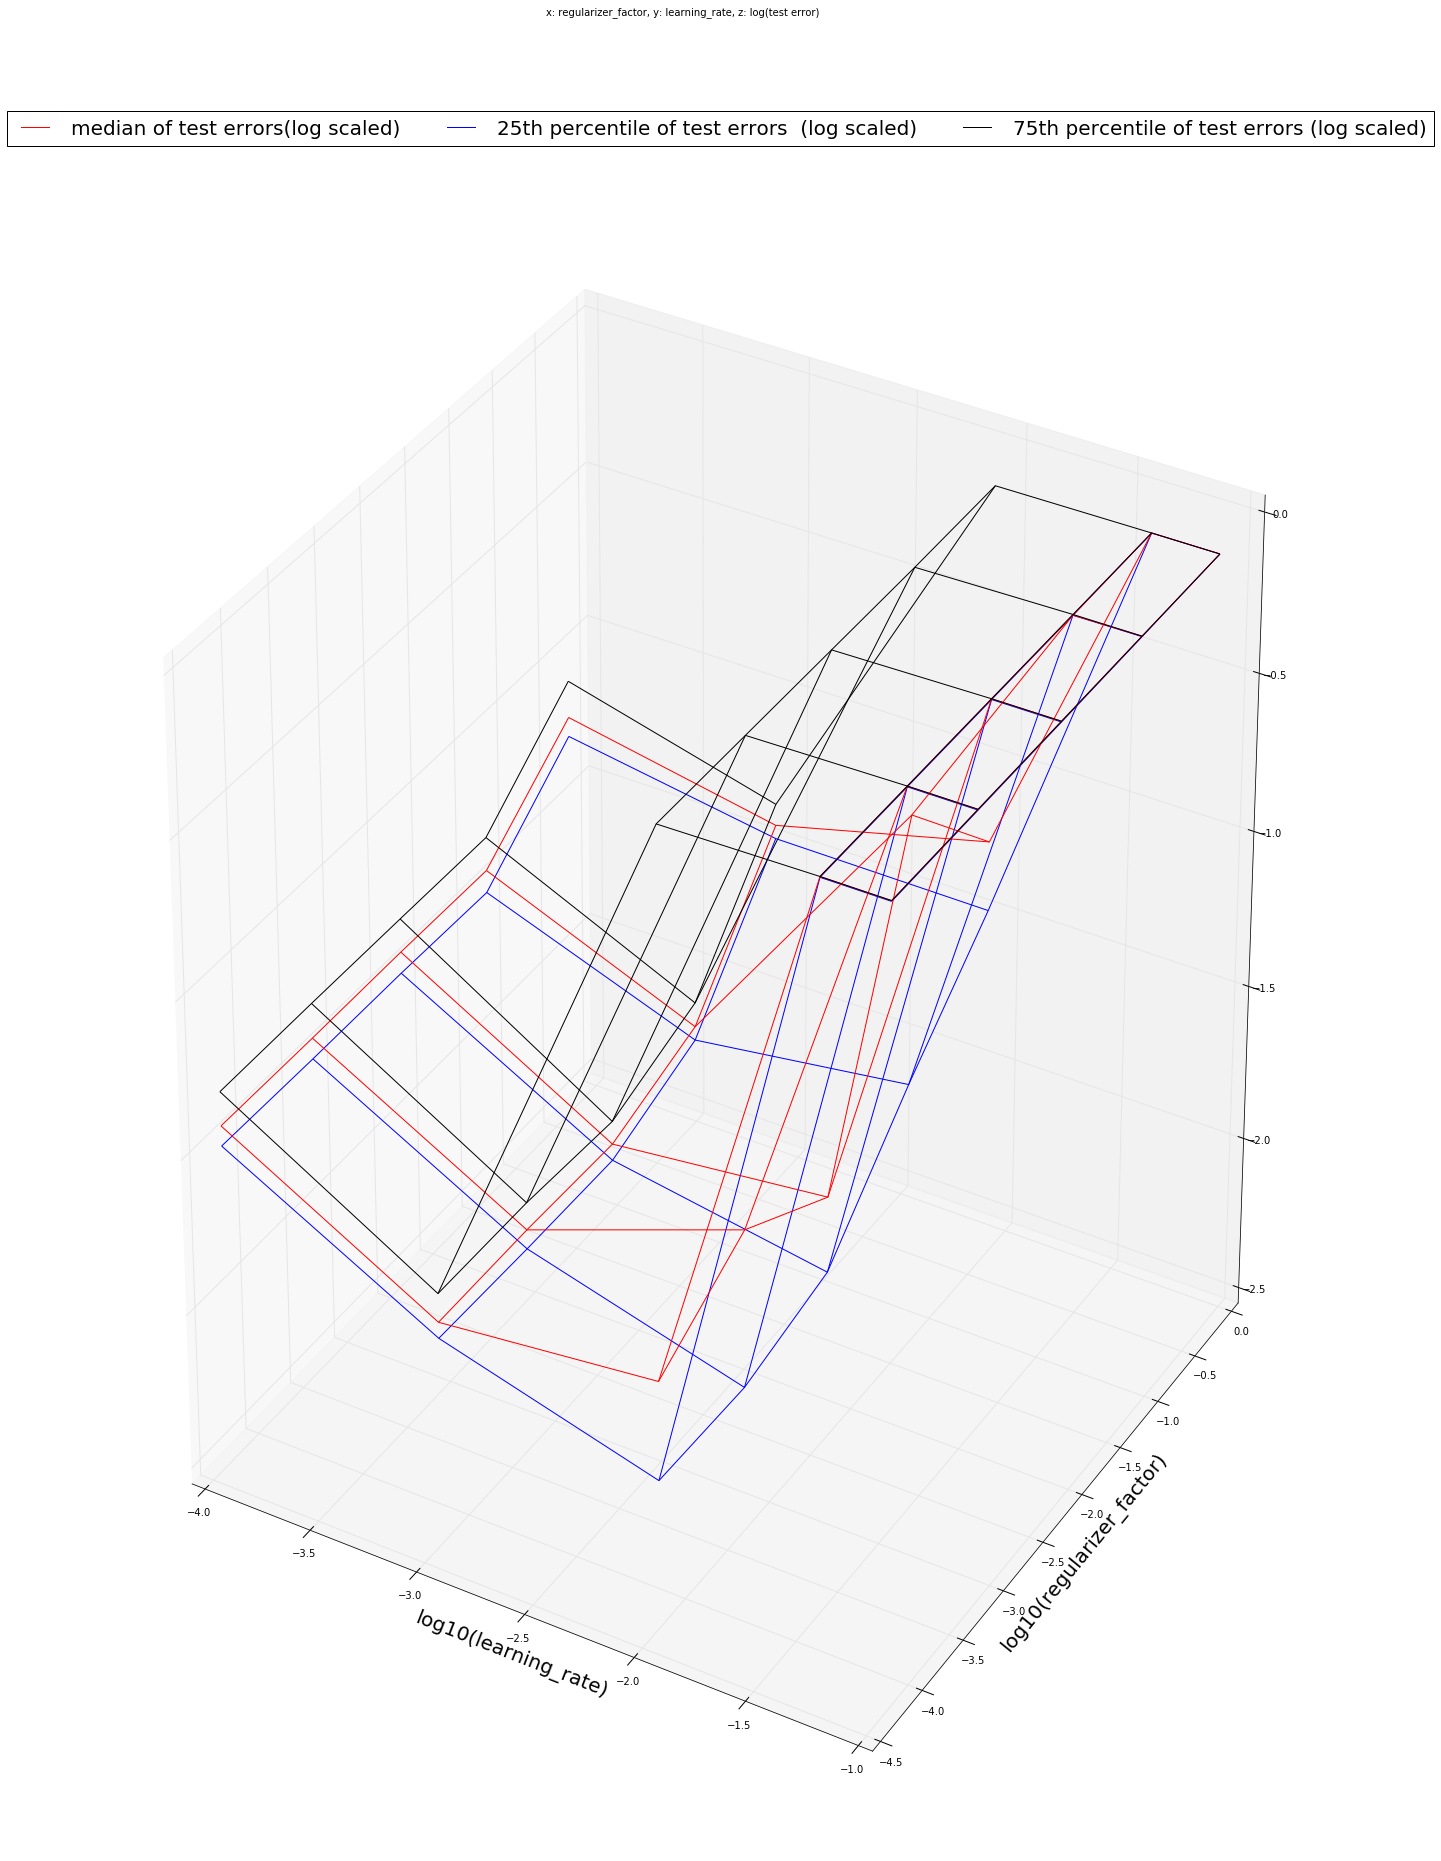

In [25]:
fig = plt.figure(figsize=(25, 30), dpi=100)
label='x: regularizer_factor, y: learning_rate, z: log(test error)'
fig.suptitle(label)

condition = {}
ax = fig.add_subplot(1, 1, 1, projection='3d')

ax.set_title(generate_title(condition), fontsize=15)
#ax.set_xlim([np.log2(0), np.log2(max(dropout_rates))])
#ax.set_ylim([np.log2(0), np.log2(max((learning_rates)))])

ax.set_zlim([-2.5, 0])
median_dataset = generate_data_list("BASE_LEARNING_RATE", learning_rates, "REGULARIZER_FACTOR", reg_factors, \
                                       "Test Error", condition, "median")
X, Y, Z = transform(median_dataset, len(learning_rates))
ax.plot_wireframe(X, Y, Z, rstride=1, cstride=1, label = 'median of test errors(log scaled)', color='red')

p25_dataset = generate_data_list("BASE_LEARNING_RATE", learning_rates, "REGULARIZER_FACTOR", reg_factors, \
                                       "Test Error", condition, "25p")
X, Y, Z = transform(p25_dataset, len(learning_rates))
ax.plot_wireframe(X, Y, Z, rstride=1, cstride=1, label = '25th percentile of test errors  (log scaled)', color='blue')

p75_dataset = generate_data_list("BASE_LEARNING_RATE", learning_rates, "REGULARIZER_FACTOR", reg_factors, \
                                       "Test Error", condition, "75p")
X, Y, Z = transform(p75_dataset, len(learning_rates))
ax.plot_wireframe(X, Y, Z, rstride=1, cstride=1, label = '75th percentile of test errors (log scaled)', color='black')    

plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=3, borderaxespad=0., fontsize=20)
ax.set_xlabel('log10(learning_rate)', fontsize=20)
ax.set_ylabel('log10(regularizer_factor)', fontsize=20)

plt.show()
fig.savefig("3dplot_learning_rate-reg_factor2.png", format='png', dpi=100, show=False)

{'REGULARIZER_FACTOR': 0.050000000000000003, 'BASE_LEARNING_RATE': 0.0001} -> 99
{'REGULARIZER_FACTOR': 0.050000000000000003, 'BASE_LEARNING_RATE': 0.10000000000000001} -> 99
{'REGULARIZER_FACTOR': 0.050000000000000003, 'BASE_LEARNING_RATE': 0.0001} -> 99
{'REGULARIZER_FACTOR': 0.050000000000000003, 'BASE_LEARNING_RATE': 0.10000000000000001} -> 99
{'REGULARIZER_FACTOR': 0.050000000000000003, 'BASE_LEARNING_RATE': 0.0001} -> 99
{'REGULARIZER_FACTOR': 0.050000000000000003, 'BASE_LEARNING_RATE': 0.10000000000000001} -> 99


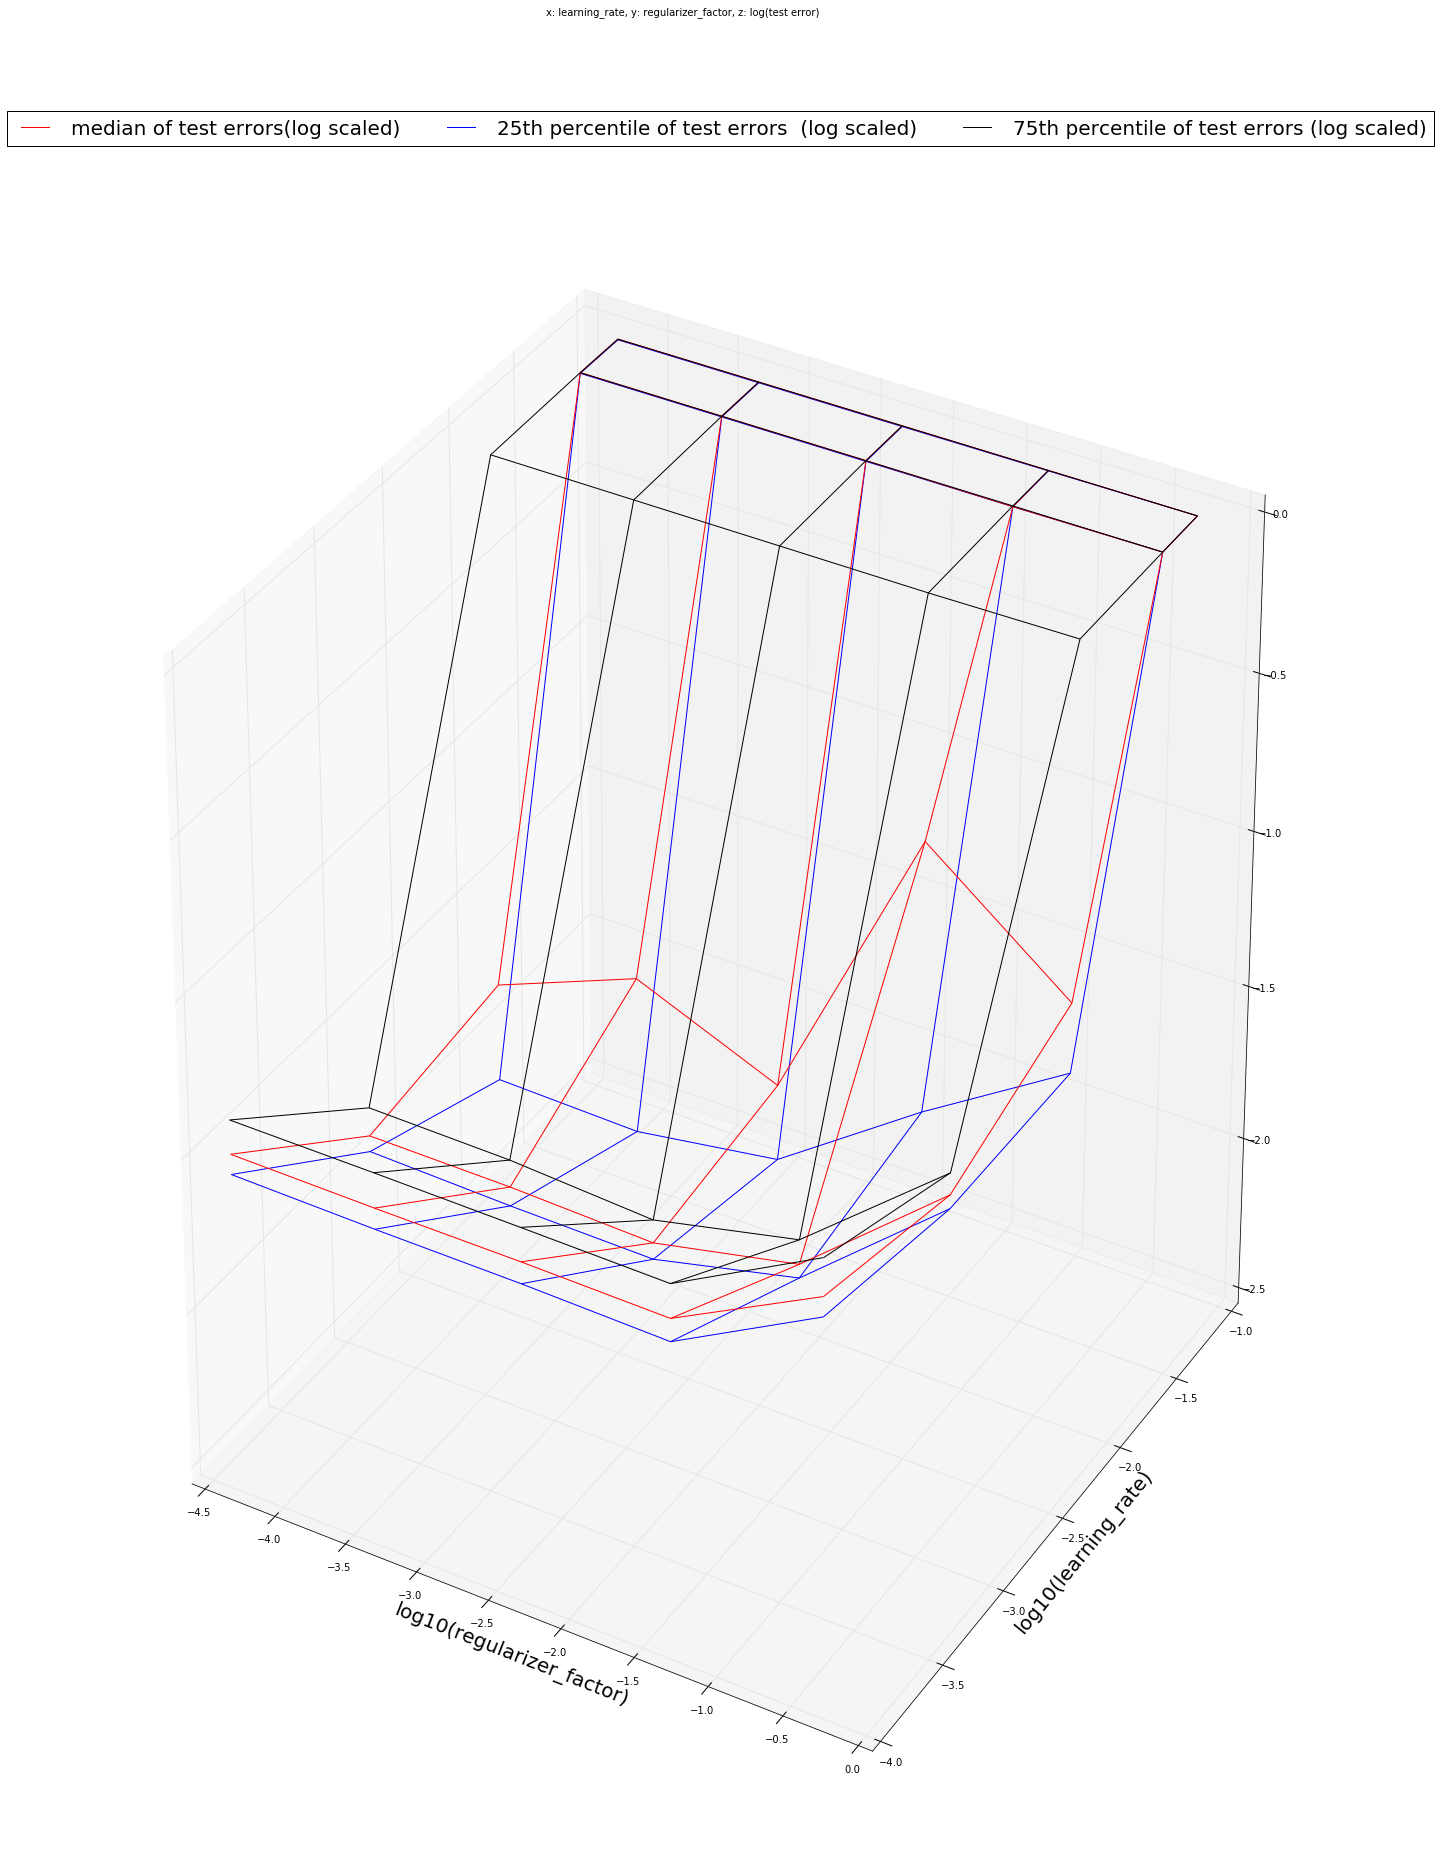

In [35]:
fig = plt.figure(figsize=(25, 30), dpi=100)
label='x: learning_rate, y: regularizer_factor, z: log(test error)'
fig.suptitle(label)

condition = {}
ax = fig.add_subplot(1, 1, 1, projection='3d')

ax.set_title(generate_title(condition), fontsize=15)
#ax.set_xlim([np.log2(0), np.log2(max(dropout_rates))])
#ax.set_ylim([np.log2(0), np.log2(max((learning_rates)))])

ax.set_zlim([-2.5, 0])
median_dataset = generate_data_list("REGULARIZER_FACTOR", reg_factors, "BASE_LEARNING_RATE", learning_rates, \
                                       "Test Error", condition, "median")
X, Y, Z = transform(median_dataset, len(learning_rates))
ax.plot_wireframe(X, Y, Z, rstride=1, cstride=1, label = 'median of test errors(log scaled)', color='red')

p25_dataset = generate_data_list("REGULARIZER_FACTOR", reg_factors, "BASE_LEARNING_RATE", learning_rates, \
                                       "Test Error", condition, "25p")
X, Y, Z = transform(p25_dataset, len(learning_rates))
ax.plot_wireframe(X, Y, Z, rstride=1, cstride=1, label = '25th percentile of test errors  (log scaled)', color='blue')

p75_dataset = generate_data_list("REGULARIZER_FACTOR", reg_factors, "BASE_LEARNING_RATE", learning_rates, \
                                       "Test Error", condition, "75p")
X, Y, Z = transform(p75_dataset, len(learning_rates))
ax.plot_wireframe(X, Y, Z, rstride=1, cstride=1, label = '75th percentile of test errors (log scaled)', color='black')    

plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=3, borderaxespad=0., fontsize=20)
ax.set_xlabel('log10(regularizer_factor)', fontsize=20)
ax.set_ylabel('log10(learning_rate)', fontsize=20)

plt.show()
fig.savefig("3dplot_learning_rate-reg_factor1.png", format='png', dpi=100, show=False)

{'REGULARIZER_FACTOR': 0.050000000000000003, 'BASE_LEARNING_RATE': 0.0001} -> 99
{'REGULARIZER_FACTOR': 0.050000000000000003, 'BASE_LEARNING_RATE': 0.10000000000000001} -> 99
{'REGULARIZER_FACTOR': 0.050000000000000003, 'BASE_LEARNING_RATE': 0.0001} -> 99
{'REGULARIZER_FACTOR': 0.050000000000000003, 'BASE_LEARNING_RATE': 0.10000000000000001} -> 99
{'REGULARIZER_FACTOR': 0.050000000000000003, 'BASE_LEARNING_RATE': 0.0001} -> 99
{'REGULARIZER_FACTOR': 0.050000000000000003, 'BASE_LEARNING_RATE': 0.10000000000000001} -> 99


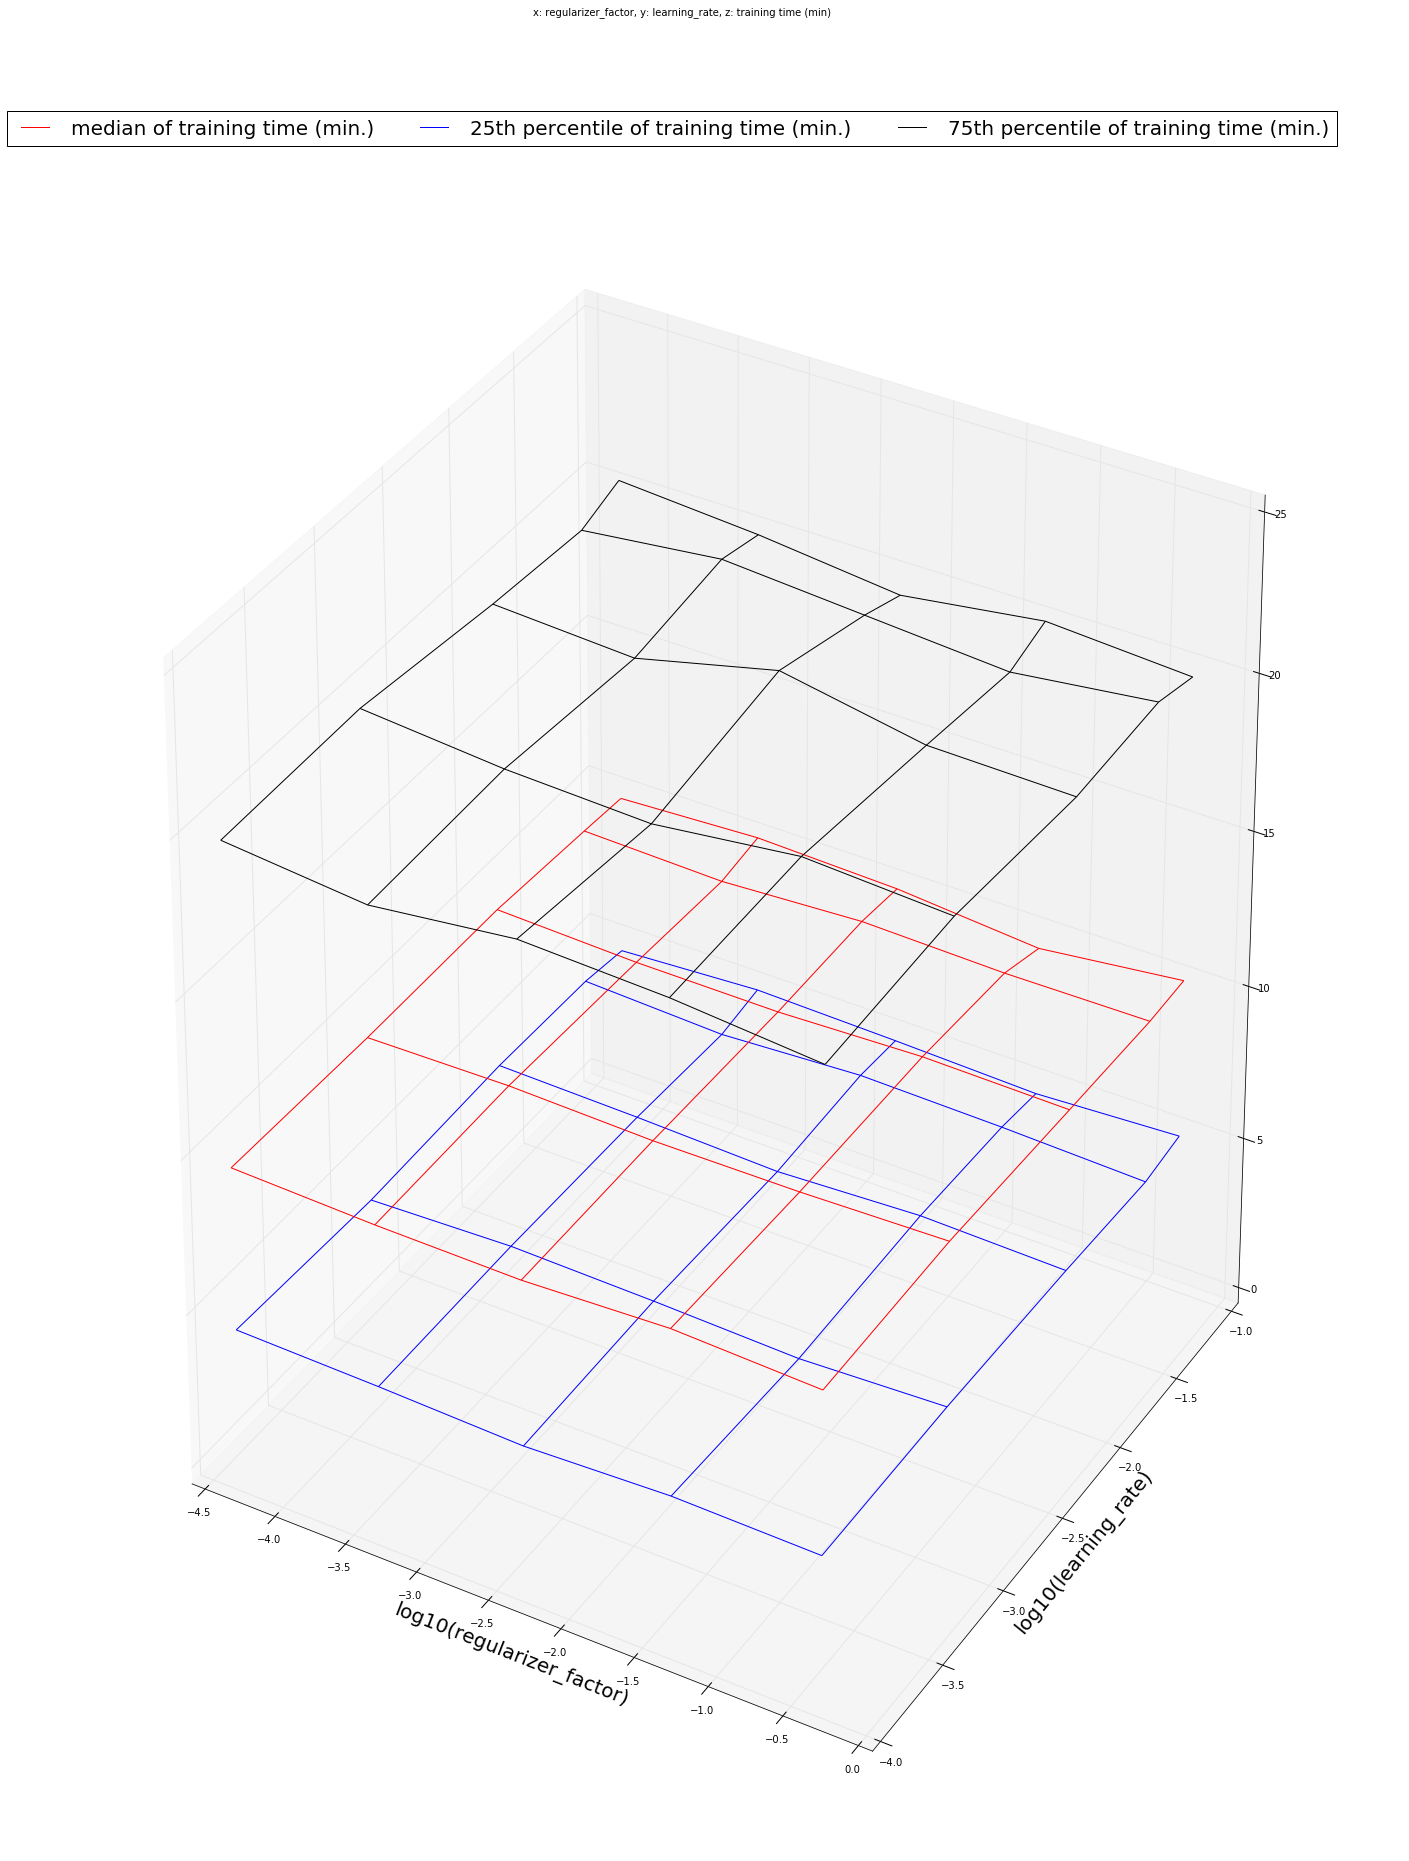

In [36]:
fig = plt.figure(figsize=(25, 30), dpi=100)
label='x: regularizer_factor, y: learning_rate, z: training time (min)'
fig.suptitle(label)

condition = {}
ax = fig.add_subplot(1, 1, 1, projection='3d')

ax.set_title(generate_title(condition), fontsize=15)

ax.set_zlim([-2.5, 0])
median_dataset = generate_data_list("REGULARIZER_FACTOR", reg_factors, "BASE_LEARNING_RATE", learning_rates, \
                                       "Elapsed Time", condition, "median")
X, Y, Z = transform(median_dataset, len(reg_factors))
ax.plot_wireframe(X, Y, Z, rstride=1, cstride=1, label = 'median of training time (min.)', color='red')

p25_dataset = generate_data_list("REGULARIZER_FACTOR", reg_factors, "BASE_LEARNING_RATE", learning_rates, \
                                       "Elapsed Time", condition, "25p")
X, Y, Z = transform(p25_dataset, len(reg_factors))
ax.plot_wireframe(X, Y, Z, rstride=1, cstride=1, label = '25th percentile of training time (min.)', color='blue')

p75_dataset = generate_data_list("REGULARIZER_FACTOR", reg_factors, "BASE_LEARNING_RATE", learning_rates, \
                                       "Elapsed Time", condition, "75p")
X, Y, Z = transform(p75_dataset, len(reg_factors))
ax.plot_wireframe(X, Y, Z, rstride=1, cstride=1, label = '75th percentile of training time (min.)', color='black')    

plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=3, borderaxespad=0., fontsize=20)
ax.set_xlabel('log10(regularizer_factor)', fontsize=20)
ax.set_ylabel('log10(learning_rate)', fontsize=20)
ax.set_zlim([0, 25])
plt.show()
fig.savefig("3dplot_learning_rate-reg_factor1-time.png", format='png', dpi=100, show=False)